In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# Verify GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Define the paths to your dataset files
data_files = {
    'train': 'severity_data_train.csv',
    'val': 'severity_data_val.csv',
    'test': 'severity_data_test.csv'
}

# Load the dataset
datasets = load_dataset('csv', data_files=data_files)

# Define a mapping dictionary
severity_mapping = {"low": 0, "medium": 1, "high": 2}

# Map the string labels to integers
datasets = datasets.map(lambda example: {'labels': severity_mapping[example['severity']]})

# Optionally, remove the original 'severity' column if you don't need it
datasets = datasets.remove_columns('severity')

# Initialize the tokenizer for CodeBERT
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-base', num_labels=3)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['vuln_explanation'], padding='max_length', truncation=True, max_length=256)

# Apply tokenization to the datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Set the format for PyTorch
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load the pre-trained CodeBERT model with a classification head
model = AutoModelForSequenceClassification.from_pretrained('Salesforce/codet5-base', num_labels=3)

# Move the model to the appropriate device
model.to(device)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to = "none",
    no_cuda=not torch.cuda.is_available(),  # Disable CUDA if not available
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['val'],
)

# Fine-tune the model
trainer.train()

# Evaluate the model
trainer.evaluate()

2025-06-09 09:42:19.180124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749462139.406701      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749462139.475153      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training on: cuda


Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/662 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Map:   0%|          | 0/662 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at Salesforce/codet5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.084200
2,No log,1.049149
3,No log,1.095684
4,No log,1.053523
5,No log,1.036857


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 

{'eval_loss': 1.0368571281433105,
 'eval_runtime': 4.0583,
 'eval_samples_per_second': 34.99,
 'eval_steps_per_second': 2.218,
 'epoch': 5.0}

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

         low       0.52      0.54      0.53        24
      medium       0.52      0.58      0.55        74
        high       0.39      0.31      0.35        45

    accuracy                           0.49       143
   macro avg       0.48      0.48      0.48       143
weighted avg       0.48      0.49      0.48       143



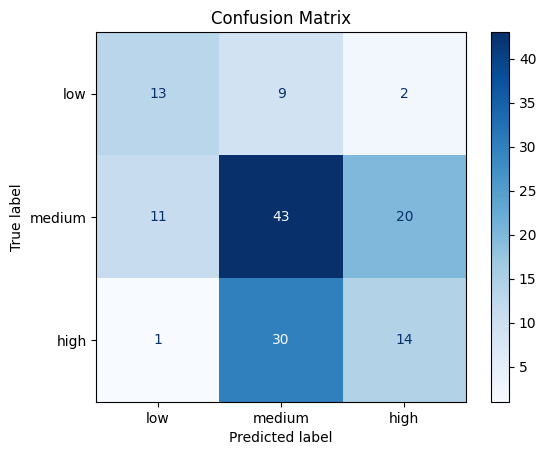

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make predictions
predictions = trainer.predict(tokenized_datasets['test'])
preds = np.argmax(predictions.predictions[0], axis=-1)
true_labels = predictions.label_ids

# Generate the classification report
report = classification_report(true_labels, preds, target_names=['low', 'medium', 'high'])
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low', 'medium', 'high'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Define the directory where the model and tokenizer will be saved
save_directory = "./severity_codet5"

# Save the fine-tuned model
trainer.save_model(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)